# Task 1: Fine-tune Chemical Language Model

The goal is to fine-tune a pre-trained chemical language model on a regression task using the Lipophilicity dataset. The task involves predicting the lipophilicity value for a given molecule representation (SMILES string). You will learn how to load and tokenize a dataset from HuggingFace, how to load a pre-trained language model, and finally, how to run a model in inference mode.

Your task is to complete the missing code blocks below.

In [ ]:
pip install datasets transformers torch


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 20.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 83.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 63.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 42.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 78.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
# import dependencies
import torch
from datasets import load_dataset
import torch.nn as nn
from transformers import AutoModel, AutoTokenizer, AutoModelForMaskedLM, DataCollatorForLanguageModeling
from torch.utils.data import DataLoader, Dataset, Subset
from sklearn.model_selection import train_test_split
import pandas as pd
from tqdm.notebook import tqdm
import random
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tqdm import tqdm

# 1.Fine-tune a Chemical Language Model on Lipophilicity


## --- Step 1: Load Dataset ---

The dataset we are going to use is the [Lipophilicity](https://huggingface.co/datasets/scikit-fingerprints/MoleculeNet_Lipophilicity) dataset, part of [MoleculeNet](https://pubs.rsc.org/en/content/articlelanding/2018/sc/c7sc02664a) benchmark.

Lipophilicity, also known as hydrophobicity, is a measure of how readily a substance dissolves in nonpolar solvents (such as oil) compared to polar solvents (such as water).

In [ ]:
# specify dataset name and model name
DATASET_PATH = "scikit-fingerprints/MoleculeNet_Lipophilicity"
MODEL_NAME = "ibm/MoLFormer-XL-both-10pct"  #MoLFormer model

In [ ]:
# load the dataset from HuggingFace
dataset = load_dataset(DATASET_PATH)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/1.16k [00:00<?, ?B/s]

lipophilicity.csv:   0%|          | 0.00/223k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/4200 [00:00<?, ? examples/s]

In [ ]:
# Explore the dataset
# For example, print the column names and display a few sample rows
# TODO: your code goes here
# Print column names
print("Column Names:", dataset["train"].column_names)

# Display a few sample rows
print("\nSample Rows:")
print(dataset["train"].to_pandas().head())



Column Names: ['SMILES', 'label']

Sample Rows:
                                              SMILES  label
0            Cn1c(CN2CCN(CC2)c3ccc(Cl)cc3)nc4ccccc14   3.54
1  COc1cc(OC)c(cc1NC(=O)CSCC(=O)O)S(=O)(=O)N2C(C)...  -1.18
2             COC(=O)[C@@H](N1CCc2sccc2C1)c3ccccc3Cl   3.69
3  OC[C@H](O)CN1C(=O)C(Cc2ccccc12)NC(=O)c3cc4cc(C...   3.37
4  Cc1cccc(C[C@H](NC(=O)c2cc(nn2C)C(C)(C)C)C(=O)N...   3.10


In [ ]:
# define a PyTorch Dataset class for handling SMILES strings and targets

# TODO: your code goes here
# class SMILESDataset(Dataset):
class SMILESDataset(Dataset):
    def __init__(self, dataset, tokenizer, max_length=128):
      self.smiles = dataset["SMILES"]
      self.tokenizer = tokenizer
      self.max_length = max_length
      self.dataset = dataset
    def __len__(self):
      return len(self.smiles)

    def __getitem__(self, idx):
      smiles = self.smiles[idx]
      label = torch.tensor(self.dataset[idx]["label"], dtype=torch.float32)

      # Tokenize the SMILES string
      encoding = self.tokenizer(
          smiles,
          padding="max_length",
          truncation=True,
          max_length=self.max_length,
          return_tensors="pt"
      )


      return {
           "input_ids": encoding["input_ids"].squeeze(0),  # Remove extra batch dimension
           "attention_mask": encoding["attention_mask"].squeeze(0),
           "labels": label
        }


## --- Step 2: Split Dataset ---

As there is only one split (train split) in the original dataset, we need to split the data into training and testing sets by ourselves.

In [ ]:
# tokenize the data
# load a pre-trained tokenizer from HuggingFace
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, trust_remote_code=True)



tokenizer_config.json:   0%|          | 0.00/1.29k [00:00<?, ?B/s]

tokenization_molformer_fast.py:   0%|          | 0.00/6.50k [00:00<?, ?B/s]

tokenization_molformer.py:   0%|          | 0.00/9.48k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/ibm/MoLFormer-XL-both-10pct:
- tokenization_molformer.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/ibm/MoLFormer-XL-both-10pct:
- tokenization_molformer_fast.py
- tokenization_molformer.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


vocab.json:   0%|          | 0.00/41.6k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/54.0k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

In [ ]:
# split the data into training and test datasets
# TODO: your code goes here
train_test_split = dataset["train"].train_test_split(test_size=0.2, seed=42)
train_dataset = train_test_split["train"]
test_dataset = train_test_split["test"]

# Check dataset sizes
print(f"Training size: {len(train_dataset)}, Test size: {len(test_dataset)}")


Training size: 3360, Test size: 840


In [ ]:
# construct Pytorch data loaders for both train and test datasets

# Create dataset instances
train_data = SMILESDataset(train_dataset, tokenizer)
test_data = SMILESDataset(test_dataset, tokenizer)


BATCH_SIZE = 16

# TODO: your code goes here
# Create DataLoaders
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)


#to check the sample batch
train_iterator = iter(train_loader)
sample_batch = next(train_iterator)

print(sample_batch.keys())






dict_keys(['input_ids', 'attention_mask', 'labels'])


## --- Step 3: Load Model ---

In [ ]:
# load pre-trained model from HuggingFace
model = AutoModel.from_pretrained(MODEL_NAME, deterministic_eval=True, trust_remote_code=True)

config.json:   0%|          | 0.00/1.01k [00:00<?, ?B/s]

configuration_molformer.py:   0%|          | 0.00/7.60k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/ibm/MoLFormer-XL-both-10pct:
- configuration_molformer.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_molformer.py:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/ibm/MoLFormer-XL-both-10pct:
- modeling_molformer.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


model.safetensors:   0%|          | 0.00/187M [00:00<?, ?B/s]

In [ ]:
# We need to add a regression head on the language model as we are doing a regression task.

# specify model with a regression head

class MoLFormerWithRegressionHead(nn.Module):
  # TODO: your code goes here
  def __init__(self, base_model):
    super(MoLFormerWithRegressionHead, self).__init__()
    # Load the pretrained MoLFormer model
    self.molformer = base_model # Use the loaded model
    self.regression_head = nn.Linear(self.molformer.config.hidden_size, 1)

  def forward(self, input_ids, attention_mask):
      outputs = self.molformer(input_ids=input_ids, attention_mask=attention_mask)
      pooled_output = outputs.pooler_output # Use pooler_output
      return self.regression_head(pooled_output)


In [ ]:
# initialize the regression model

MODEL_NAME = "ibm/MoLFormer-XL-both-10pct"

# Load the pretrained model first
base_model = AutoModel.from_pretrained(MODEL_NAME, trust_remote_code=True)


# Initialize model with the loaded base model
model = MoLFormerWithRegressionHead(base_model)

# Move to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print(model)


MoLFormerWithRegressionHead(
  (molformer): MolformerModel(
    (embeddings): MolformerEmbeddings(
      (word_embeddings): Embedding(2362, 768, padding_idx=2)
      (dropout): Dropout(p=0.2, inplace=False)
    )
    (encoder): MolformerEncoder(
      (layer): ModuleList(
        (0-11): 12 x MolformerLayer(
          (attention): MolformerAttention(
            (self): MolformerSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (rotary_embeddings): MolformerRotaryEmbedding()
              (feature_map): MolformerFeatureMap(
                (kernel): ReLU()
              )
            )
            (output): MolformerSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
  

## --- Step 4: Training ---

In [ ]:
# TODO: your code goes here

# Define loss function (Mean Squared Error for regression)
loss_function = nn.MSELoss()

# Define optimizer
optimizer = optim.AdamW(model.parameters(), lr=5e-5)

# Set the number of training epochs
epochs = 10


# Training loop
for epoch in range(epochs):
    model.train()
    total_loss = 0

    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
      # Zero gradients
      optimizer.zero_grad()

      # Move batch data to device
      input_ids = batch["input_ids"].to(device)
      attention_mask = batch["attention_mask"].to(device)
      labels = batch["labels"].to(device)


      # Forward pass
      outputs = model(input_ids, attention_mask)
      outputs = outputs.squeeze()  # Remove extra dimension from the output
      loss = loss_function(outputs, labels)


      # Backward pass
      loss.backward()

      # Update weights
      optimizer.step()
      total_loss += loss.item()

    average_loss = total_loss/len(train_loader)
    print(f"Epoch: {epoch+1}, Average Loss: {average_loss:.4f}")


Epoch 1/10: 100%|██████████| 210/210 [00:43<00:00,  4.87it/s]


Epoch: 1, Average Loss: 0.9725


Epoch 2/10: 100%|██████████| 210/210 [00:44<00:00,  4.75it/s]


Epoch: 2, Average Loss: 0.4826


Epoch 3/10: 100%|██████████| 210/210 [00:46<00:00,  4.49it/s]


Epoch: 3, Average Loss: 0.3246


Epoch 4/10: 100%|██████████| 210/210 [00:45<00:00,  4.59it/s]


Epoch: 4, Average Loss: 0.2446


Epoch 5/10: 100%|██████████| 210/210 [00:46<00:00,  4.53it/s]


Epoch: 5, Average Loss: 0.1986


Epoch 6/10: 100%|██████████| 210/210 [00:45<00:00,  4.57it/s]


Epoch: 6, Average Loss: 0.1688


Epoch 7/10: 100%|██████████| 210/210 [00:46<00:00,  4.56it/s]


Epoch: 7, Average Loss: 0.1364


Epoch 8/10: 100%|██████████| 210/210 [00:46<00:00,  4.55it/s]


Epoch: 8, Average Loss: 0.1303


Epoch 9/10: 100%|██████████| 210/210 [00:46<00:00,  4.52it/s]


Epoch: 9, Average Loss: 0.1120


Epoch 10/10: 100%|██████████| 210/210 [00:46<00:00,  4.54it/s]

Epoch: 10, Average Loss: 0.1100


## --- Step 5: Evaluation ---

Evaluating: 100%|██████████| 53/53 [00:04<00:00, 12.43it/s]


Epoch: 10, Average Test Loss: 0.3893
Mean Squared Error (MSE): 0.3916
Mean Absolute Error (MAE): 0.4727
R² Score: 0.7218


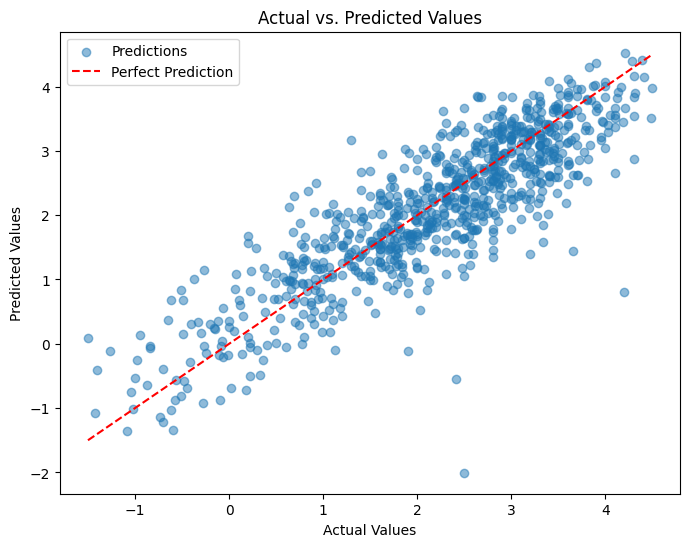

In [ ]:

# Set model to evaluation mode
model.eval()
total_eval_loss = 0
all_labels = []
all_preds = []

# Disable gradient calculations during evaluation
with torch.no_grad():
    for batch in tqdm(test_loader, desc="Evaluating"):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        # Forward pass (Fix argument order)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        outputs = outputs.squeeze()

        # Store labels and predictions
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(outputs.cpu().numpy())

        # Compute loss
        loss = loss_function(outputs, labels)
        total_eval_loss += loss.item()

# Compute average loss
average_eval_loss = total_eval_loss / len(test_loader)

# Convert lists to NumPy arrays for evaluation
import numpy as np
all_labels = np.array(all_labels)
all_preds = np.array(all_preds)

# Compute evaluation metrics
mse = mean_squared_error(all_labels, all_preds)
mae = mean_absolute_error(all_labels, all_preds)
r2 = r2_score(all_labels, all_preds)

# Print results
print(f"Epoch: {epoch+1}, Average Test Loss: {average_eval_loss:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R² Score: {r2:.4f}")

# Plot Predicted vs. Actual Values
plt.figure(figsize=(8, 6))
plt.scatter(all_labels, all_preds, alpha=0.5, label="Predictions")
plt.plot([all_labels.min(), all_labels.max()], [all_labels.min(), all_labels.max()], 'r--', label="Perfect Prediction")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted Values")
plt.legend()
plt.show()




# 2.Add Unsupervised Finetuning
In this step, you will perform unsupervised fine-tuning on the training dataset. This means the model will leverage only the SMILES strings without any corresponding labels to adapt its understanding of the data distribution. By familiarizing the model with the patterns and structure of the SMILES strings, you can potentially enhance its performance on downstream supervised tasks.

For this fine-tuning, you will use the Masked Language Modeling (MLM) objective, where the model learns to predict randomly masked tokens within the input sequence. Remember to save the fine-tuned model for later use.


In [ ]:
# TODO: your code goes here
from transformers import DataCollatorForLanguageModeling
from torch.utils.data import DataLoader

# Load the tokenizer again in case it was overwritten
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, trust_remote_code=True)

# Initialize the MLM model
mlm_model = AutoModelForMaskedLM.from_pretrained(MODEL_NAME, trust_remote_code=True)
mlm_model.to(device)

# Data Collator for MLM
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=True,
    mlm_probability=0.15 #
)

# Load training dataset
train_data = SMILESDataset(train_dataset, tokenizer)

# Create data loader
mlm_train_loader = DataLoader(
    train_data,
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=data_collator
)

# Optimizer
optimizer = optim.AdamW(mlm_model.parameters(), lr=5e-5)

# Training parameters
num_epochs = 10 # adjust based on available time and resources

# Training loop for MLM
for epoch in range(num_epochs):
  mlm_model.train()
  total_loss = 0

  for batch in tqdm(mlm_train_loader, desc=f"MLM Epoch {epoch+1}/{num_epochs}"):
    # Clear gradients
    optimizer.zero_grad()

    # Move batch to the correct device
    batch = {k: v.to(device) for k, v in batch.items()}

    # Forward pass
    outputs = mlm_model(output_hidden_states=True, **batch) # Remove the explicit labels argument
    loss = outputs.loss

    # Backward pass
    loss.backward()

    # Update model weights
    optimizer.step()
    total_loss += loss.item()

  avg_loss = total_loss/len(mlm_train_loader)
  print(f"MLM Epoch: {epoch+1}, Average Loss: {avg_loss:.4f}")

print("MLM fine-tuning complete!")


# Save the fine-tuned model
mlm_model.save_pretrained("molformer_mlm_finetuned") # You can specify a different path
print("MLM finetuned model saved.")

MLM Epoch 1/10: 100%|██████████| 210/210 [00:50<00:00,  4.13it/s]


MLM Epoch: 1, Average Loss: 0.2884


MLM Epoch 2/10: 100%|██████████| 210/210 [00:48<00:00,  4.30it/s]


MLM Epoch: 2, Average Loss: 0.1997


MLM Epoch 3/10: 100%|██████████| 210/210 [00:49<00:00,  4.26it/s]


MLM Epoch: 3, Average Loss: 0.1724


MLM Epoch 4/10: 100%|██████████| 210/210 [00:49<00:00,  4.28it/s]


MLM Epoch: 4, Average Loss: 0.1649


MLM Epoch 5/10: 100%|██████████| 210/210 [00:48<00:00,  4.29it/s]


MLM Epoch: 5, Average Loss: 0.1527


MLM Epoch 6/10: 100%|██████████| 210/210 [00:48<00:00,  4.33it/s]


MLM Epoch: 6, Average Loss: 0.1412


MLM Epoch 7/10: 100%|██████████| 210/210 [00:48<00:00,  4.32it/s]


MLM Epoch: 7, Average Loss: 0.1410


MLM Epoch 8/10: 100%|██████████| 210/210 [00:48<00:00,  4.33it/s]


MLM Epoch: 8, Average Loss: 0.1435


MLM Epoch 9/10: 100%|██████████| 210/210 [00:48<00:00,  4.33it/s]


MLM Epoch: 9, Average Loss: 0.1303


MLM Epoch 10/10: 100%|██████████| 210/210 [00:48<00:00,  4.33it/s]


MLM Epoch: 10, Average Loss: 0.1325
MLM fine-tuning complete!
MLM finetuned model saved.


# 3.Fine-Tune for Comparison
After performing unsupervised fine-tuning on the training data, we now fine-tune the model on the regression task with the regression head. By comparing the performance of the model before and after unsupervised fine-tuning, you can evaluate how the unsupervised fine-tuning impacts the model's performance on our target task.


In [ ]:
import torch.optim as optim
import torch.nn as nn
from tqdm import tqdm
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Use fine-tuned MLM model for regression
mlm_finetuned_model = AutoModel.from_pretrained("molformer_mlm_finetuned", config=config, trust_remote_code=True)

# Add regression head
mlm_finetuned_regression_model = MoLFormerWithRegressionHead(mlm_finetuned_model).to(device)

# Define loss function (Huber Loss is more robust)
loss_function = nn.SmoothL1Loss(beta=1.0)

# Optimizer (Lower LR for fine-tuning)
optimizer = optim.AdamW(mlm_finetuned_regression_model.parameters(), lr=2e-5, weight_decay=1e-2)

# Gradient Clipping
max_grad_norm = 1.0

# Set number of training epochs
epochs = 10  # Train for more epochs

#  Training loop
for epoch in range(epochs):
    mlm_finetuned_regression_model.train()
    total_loss = 0

    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
        optimizer.zero_grad()

        # Move batch to GPU
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        # Forward pass
        outputs = mlm_finetuned_regression_model(input_ids=input_ids, attention_mask=attention_mask).squeeze()

        # Compute loss
        loss = loss_function(outputs, labels)

        # Backward pass
        loss.backward()

        # Apply gradient clipping
        torch.nn.utils.clip_grad_norm_(mlm_finetuned_regression_model.parameters(), max_grad_norm)

        # Update weights
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f" Epoch: {epoch+1}, Avg Loss: {avg_loss:.4f}")



def print_metrics(actuals, predictions):

    mse = mean_squared_error(actuals, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actuals, predictions)
    r2 = r2_score(actuals, predictions)

    print(f" Regression Evaluation Metrics:")
    print(f"🔹 MSE:  {mse:.4f}")
    print(f"🔹 RMSE: {rmse:.4f}")
    print(f"🔹 MAE:  {mae:.4f}")
    print(f"🔹 R² Score: {r2:.4f}")


print("Evaluating Fine-Tuned Model (Regression)")
actuals_after, predictions_after = evaluate_model(mlm_finetuned_regression_model, test_loader)

print("\n AFTER Fine-Tuning:")
print_metrics(actuals_after, predictions_after)


Epoch 1/10: 100%|██████████| 210/210 [00:48<00:00,  4.35it/s]


✅ Epoch: 1, Avg Loss: 0.4943


Epoch 2/10: 100%|██████████| 210/210 [00:46<00:00,  4.52it/s]


✅ Epoch: 2, Avg Loss: 0.2766


Epoch 3/10: 100%|██████████| 210/210 [00:46<00:00,  4.48it/s]


✅ Epoch: 3, Avg Loss: 0.2102


Epoch 4/10: 100%|██████████| 210/210 [00:46<00:00,  4.51it/s]


✅ Epoch: 4, Avg Loss: 0.1769


Epoch 5/10: 100%|██████████| 210/210 [00:46<00:00,  4.50it/s]


✅ Epoch: 5, Avg Loss: 0.1523


Epoch 6/10: 100%|██████████| 210/210 [00:46<00:00,  4.50it/s]


✅ Epoch: 6, Avg Loss: 0.1335


Epoch 7/10: 100%|██████████| 210/210 [00:46<00:00,  4.51it/s]


✅ Epoch: 7, Avg Loss: 0.1193


Epoch 8/10: 100%|██████████| 210/210 [00:46<00:00,  4.51it/s]


✅ Epoch: 8, Avg Loss: 0.1082


Epoch 9/10: 100%|██████████| 210/210 [00:46<00:00,  4.51it/s]


✅ Epoch: 9, Avg Loss: 0.0989


Epoch 10/10: 100%|██████████| 210/210 [00:46<00:00,  4.51it/s]


✅ Epoch: 10, Avg Loss: 0.0953
Evaluating Fine-Tuned Model (Regression)


Evaluating: 100%|██████████| 53/53 [00:04<00:00, 12.45it/s]

Evaluation Results:
MSE: 0.4234, RMSE: 0.6507, MAE: 0.4808, R² Score: 0.6993

📈 AFTER Fine-Tuning:
📊 Regression Evaluation Metrics:
🔹 MSE:  0.4234
🔹 RMSE: 0.6507
🔹 MAE:  0.4808
🔹 R² Score: 0.6993
